In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Define folder path
data_folder = '/content/drive/MyDrive/Diabetes-Data'


Mounted at /content/drive


In [ ]:
# Initialize an empty list to store each dataset
data_frames = []

# Iterate through 70 dataset files
for i in range(1, 71):
    file_path = f'{data_folder}/data-{i:02d}'
    try:
        # Read each dataset file, assuming it is tab-separated with no header
        df = pd.read_csv(file_path, sep='\t', header=None, names=['Date', 'Time', 'Code', 'Value'])
        data_frames.append(df)
    except FileNotFoundError:
      print(f"File {file_path} not found")

# Combine all datasets
if data_frames:
    combined_df = pd.concat(data_frames, ignore_index=True)
    # Generate and save as CSV file
    combined_df.to_csv('/content/drive/MyDrive/combined_diabetes_data.csv', index=False)
    print("Combined CSV file has been generated and saved as combined_diabetes_data.csv")
else:
    print("Failed to read any dataset, cannot generate combined CSV file.")

Combined CSV file has been generated and saved as combined_diabetes_data.csv


In [ ]:
import seaborn as sns

# Read data
data = pd.read_csv('/content/drive/MyDrive/combined_diabetes_data.csv')

# Data cleaning
# Handle non-numeric data, convert '0Hi' etc. to NaN
data['Value'] = pd.to_numeric(data['Value'], errors='coerce')

# Handle missing values with median imputation
imputer = SimpleImputer(strategy='median')
data['Value'] = imputer.fit_transform(data[['Value']])
# Process date and time data
data['Date'] = data['Date'].astype(str)
data['Time'] = data['Time'].astype(str)
data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], errors='coerce')

In [ ]:
# Data exploration
print(data.info())
print(data['Code'].value_counts())
print(data.groupby('Code')['Value'].describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29330 entries, 0 to 29329
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      29330 non-null  object        
 1   Time      29330 non-null  object        
 2   Code      29330 non-null  int64         
 3   Value     29330 non-null  float64       
 4   DateTime  29285 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 1.1+ MB
None
Code
33    9518
34    3830
58    3518
62    3160
60    2771
48    1883
35    1053
57     990
64     904
65     331
67     326
63     219
66     154
70     139
56     119
71      98
72      94
69      68
61      66
68      34
0       33
59      20
4        1
36       1
Name: count, dtype: int64
       count        mean         std   min    25%    50%     75%    max
Code                                                                   
0       33.0   24.000000    0.000000  24.0   

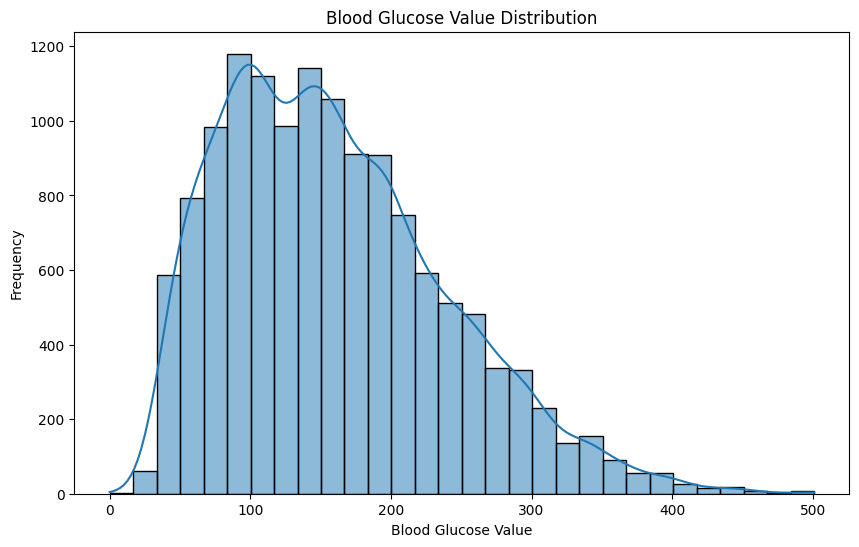

In [ ]:
# Data visualization
plt.figure(figsize=(10, 6))
sns.histplot(data[data['Code'].isin([48, 57, 58, 59, 60, 61, 62, 63, 64])]['Value'], bins=30, kde=True)
plt.title('Blood Glucose Value Distribution')
plt.xlabel('Blood Glucose Value')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Feature engineering
data['Hour'] = data['DateTime'].dt.hour
data['Day'] = data['DateTime'].dt.day
data['Month'] = data['DateTime'].dt.month

# Define target variable
data['Outcome'] = data['Value'].apply(lambda x: 1 if x > 200 else 0)

# Select features
features = ['Hour', 'Day', 'Month', 'Value']
X = data[features]
y = data['Outcome']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
# Define model training and evaluation function
def train_and_evaluate_model(model, model_name, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    print(f"{model_name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")
    joblib.dump(model, f'{model_name}_model.pkl')
    print(f"{model_name} model has been saved as {model_name}_model.pkl\n")


Random Forest - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000, AUC: 1.0000
Random Forest model has been saved as Random Forest_model.pkl

Logistic Regression - Accuracy: 0.9997, Precision: 1.0000, Recall: 0.9974, F1: 0.9987, AUC: 1.0000
Logistic Regression model has been saved as Logistic Regression_model.pkl

Gradient Boosting - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000, AUC: 1.0000
Gradient Boosting model has been saved as Gradient Boosting_model.pkl



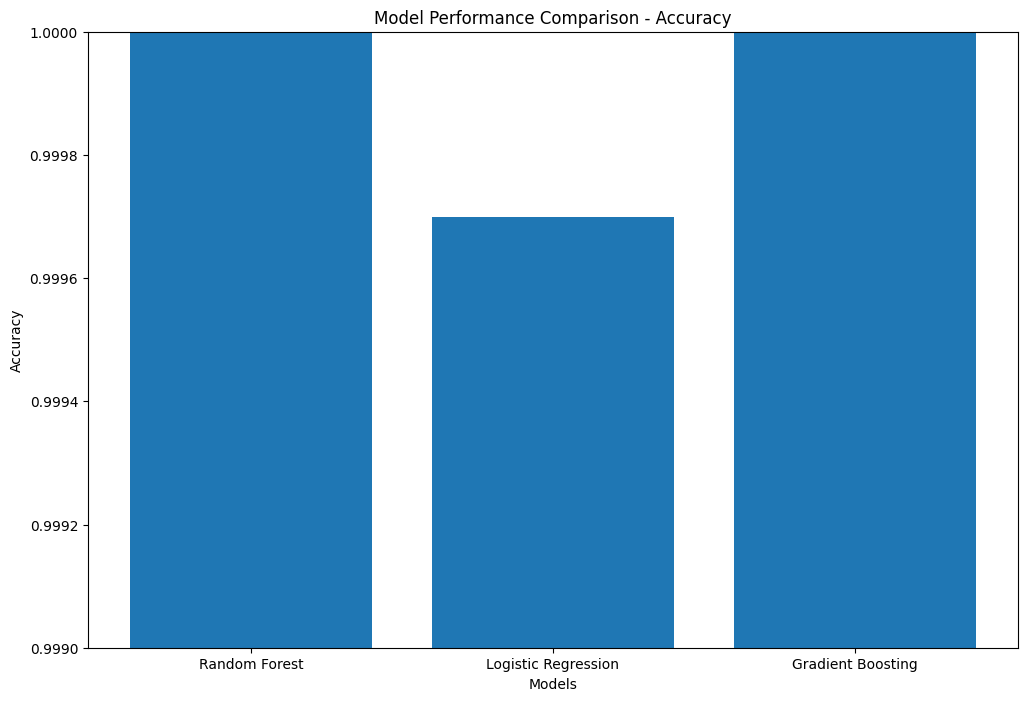

In [ ]:
# Train and evaluate models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
train_and_evaluate_model(rf_model, 'Random Forest', X_train, y_train, X_test, y_test)

lr_model = LogisticRegression(max_iter=1000)
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
train_and_evaluate_model(lr_model, 'Logistic Regression', X_train_imputed, y_train, X_test_imputed, y_test)

gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
train_and_evaluate_model(gb_model, 'Gradient Boosting', X_train_imputed, y_train, X_test_imputed, y_test)

# Visualize model performance comparison
# Define a dictionary to store model performance metrics
model_metrics = {
    'Random Forest': {'accuracy': 1.0000, 'precision': 1.0000, 'recall': 1.0000, 'f1': 1.0000, 'auc': 1.0000},
    'Logistic Regression': {'accuracy': 0.9997, 'precision': 1.0000, 'recall': 0.9974, 'f1': 0.9987, 'auc': 1.0000},
    'Gradient Boosting': {'accuracy': 1.0000, 'precision': 1.0000, 'recall': 1.0000, 'f1': 1.0000, 'auc': 1.0000}
}

# Extract accuracy data
models = list(model_metrics.keys())
accuracies = [metrics['accuracy'] for metrics in model_metrics.values()]

# Draw accuracy comparison bar chart
plt.figure(figsize=(12, 8))
plt.ylim(0.9990, 1.0000)
plt.bar(models, accuracies)
plt.title('Model Performance Comparison - Accuracy')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.show()